The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


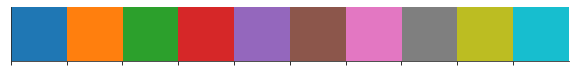

In [14]:
%load_ext autoreload
%autoreload 2
%run __init__
rs2_path = path['RSRCH'](2)

cache_path = './cache/e002'
try:
    os.mkdir(cache_path)
except:
    pass

fig_path = './figures/e002'
try:
    os.mkdir(fig_path)
except:
    pass

import importlib
e001_LL = importlib.import_module('e001-ANK-Line_Length')
e002_WV = importlib.import_module('e002-ANK-Wavelet')

stdout_orig = sys.stdout

flatui = ["#46637f", "#2ecc71", "#e74c3c", "#3498db", "#9b59b6", "#95a5a6"]
sns.palplot(sns.color_palette("tab10"))
sns.set_palette("tab10")

In [15]:
df_npref = path['CORE']['RNS']['NP_Ref']
df_ctlg = path['CORE']['RNS']['CATALOG']
TOD_DAYTIME = (7, 19)
BASELINE_DAY = 90

# PLV vs Spike Rate

In [23]:
# Grab data for NP_code    
PLV_SPK_Subject = {'NP_code': [],
                   'PLV_Band': [],
                   'PLV_Location': [],
                   'LL_Metric': [],
                   'Spearmanr': [],
                   'Pearsonr': []}

# Baseline Period
for np_code in df_npref['NP_code'].unique():
    print(np_code)
    
    try:
        key_dates = extract_key_dates(np_code)

        #####    
        W_PLV, n_exclude = e002_WV.resample_PLV(np_code, remove_blank=True, despiked=False)     
        W_LL, n_exclude = e001_LL.resample_LL(np_code, remove_blank=True)     
    except Exception as E:
        print(1)
        print(E)
        continue
        
    for band in ['Theta (4-8Hz)', 'Alpha (8-15Hz)', 'Beta (15-30Hz)', 'Gamma (30-100Hz)']:
        wplv = W_PLV[W_PLV['PLV_Band'] == band]

        for llm in ['CoVR', 'Z=3', 'Z=5']:
            wll = W_LL[llm]
            
            if len(wll) != len(wplv):
                continue
            
            for ploc in ['PLV_Global', 'PLV_Intra', 'PLV_Inter']:
                prv, pv = sp_stats.pearsonr(wll, wplv[ploc])
                srv, pv = sp_stats.spearmanr(wll, wplv[ploc])

                PLV_SPK_Subject['NP_code'].append(np_code)
                PLV_SPK_Subject['PLV_Band'].append(band)
                PLV_SPK_Subject['PLV_Location'].append(ploc)
                PLV_SPK_Subject['LL_Metric'].append(llm)
                PLV_SPK_Subject['Spearmanr'].append((srv))
                PLV_SPK_Subject['Pearsonr'].append((prv))
PLV_SPK_Subject = pd.DataFrame.from_dict(PLV_SPK_Subject)
PLV_SPK_Subject = pd.merge(df_npref[['Responder_Type', 'NP_code']], PLV_SPK_Subject, on='NP_code')

NP1
NP2
NP3
NP4
NP5
NP6
NP7
NP9
NP10
NP11
NP12
NP13
NP14
NP15
NP16
NP17
NP18
NP19
NP55
NP20
NP21
NP22
NP23
NP24
NP25
NP26
NP27
NP28
NP29
NP30
NP31
NP33
NP32
NP34
NP35
NP36
NP37
NP38
NP39
NP41
NP40
NP42
NP43
NP44
NP45
NP46
NP47
NP48
NP49
NP50
NP51


## Example Correlation

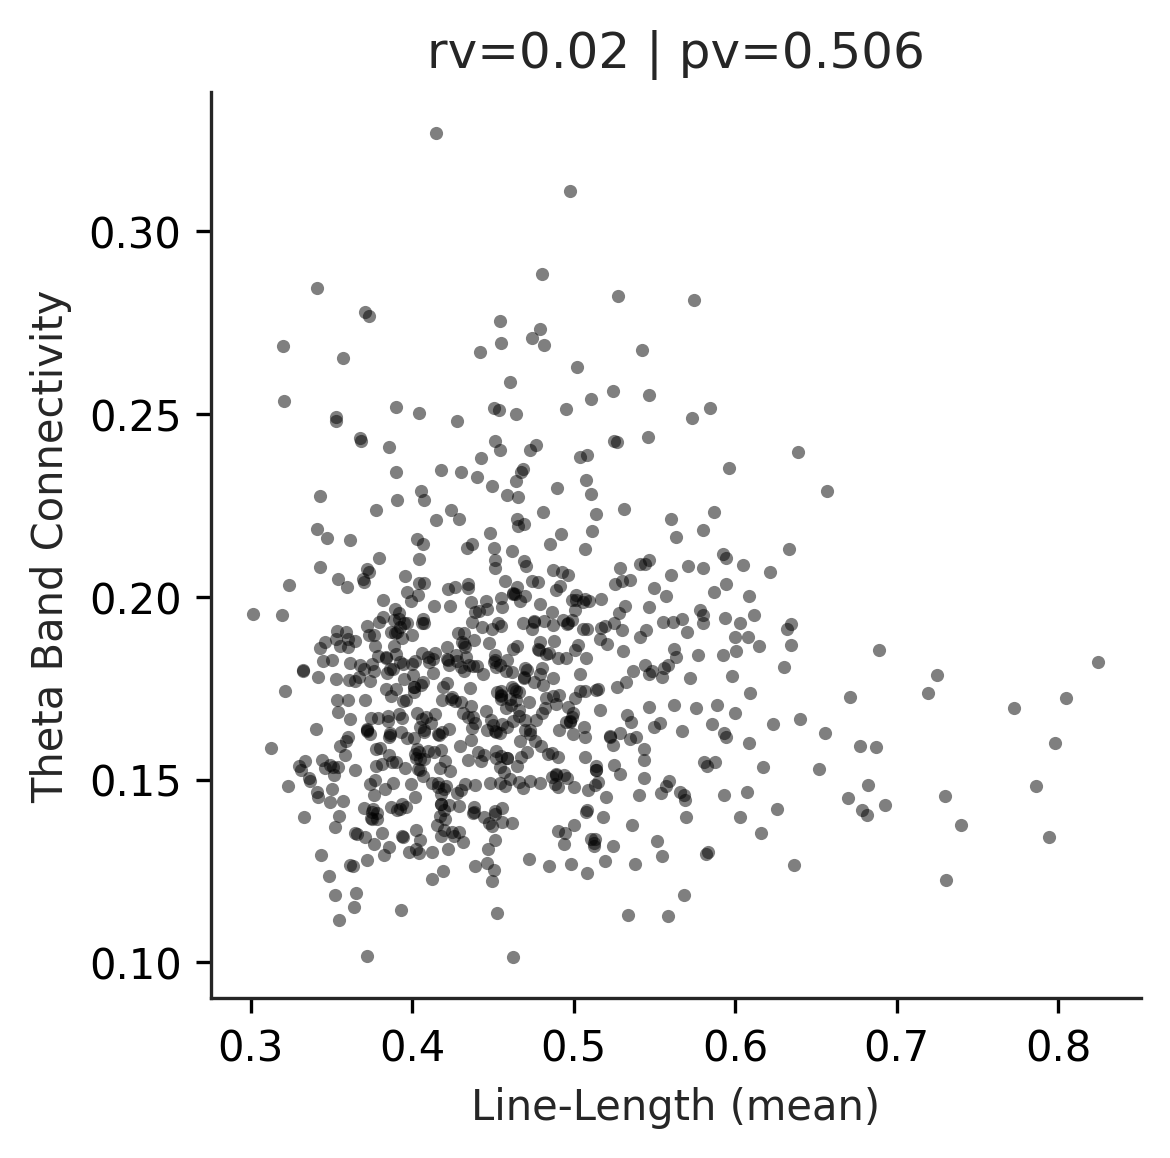

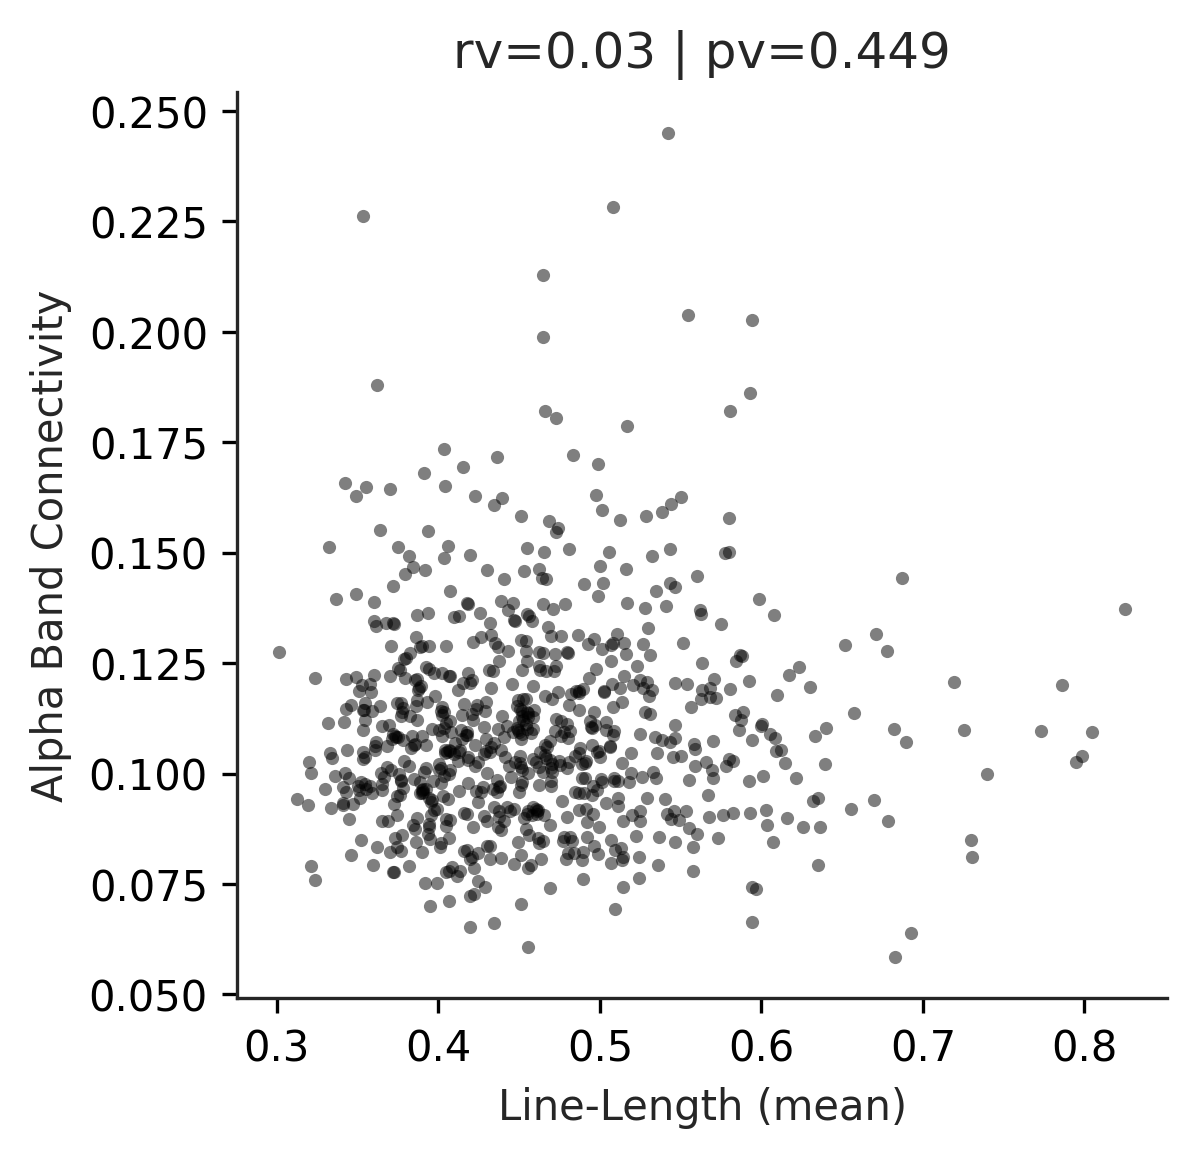

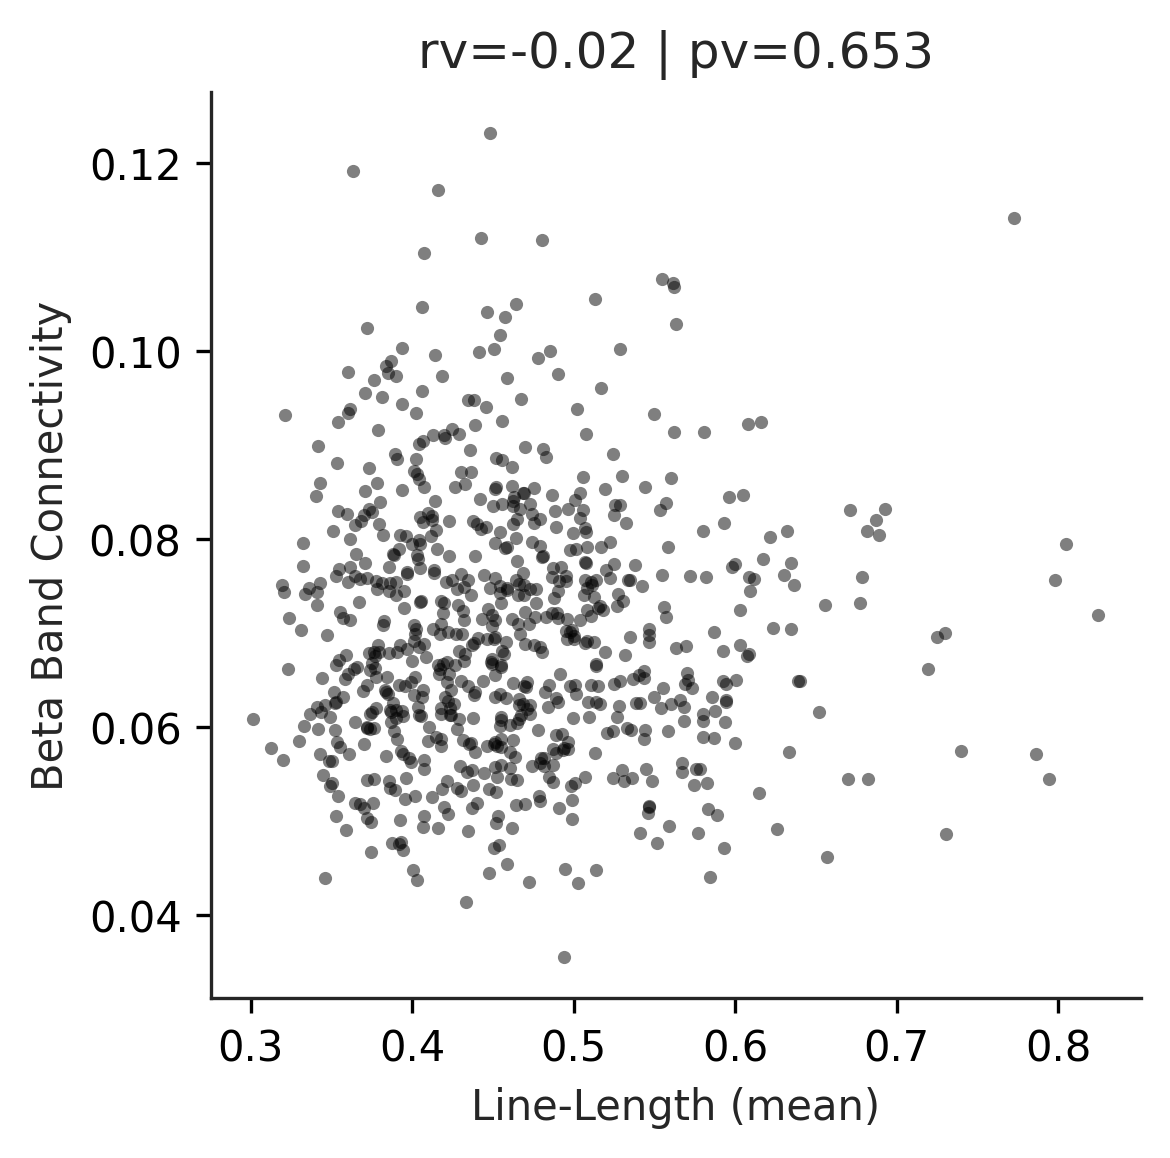

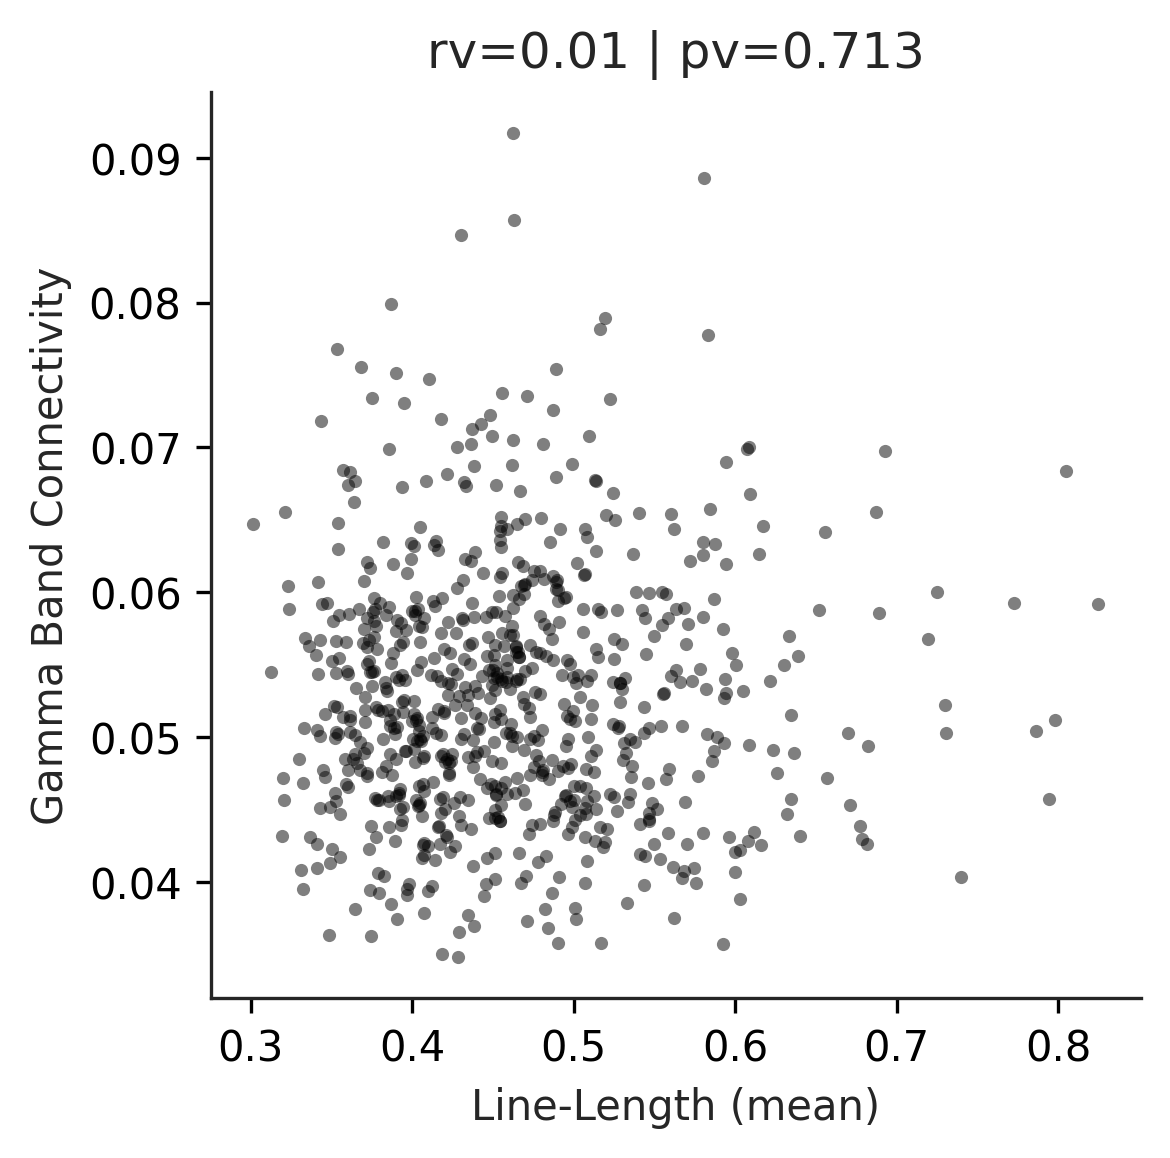

In [17]:
np_code = 'NP9'
W_PLV, n_exclude = e002_WV.resample_PLV(np_code, remove_blank=True, despiked=False)     
W_LL, n_exclude = e001_LL.resample_LL(np_code, remove_blank=True)

for xx, band in enumerate(['Theta (4-8Hz)', 'Alpha (8-15Hz)', 'Beta (15-30Hz)', 'Gamma (30-100Hz)']):
    wplv = W_PLV[W_PLV['PLV_Band'] == band]
    
    rv, pv = sp_stats.pearsonr(W_LL['CoVR'], wplv['PLV_Global'])
    
    plt.figure(figsize=(4,4), dpi=300)
    ax = plt.subplot(111)
    ax = sns.scatterplot(x=W_LL['CoVR'], y=wplv['PLV_Global'], linewidth=0, s=10, alpha=0.5, color='k', ax=ax); 
    plt.xlabel('Line-Length (mean)')
    plt.ylabel('{} Band Connectivity'.format(band.split(' ')[0]))
    plt.title('rv={:0.2f} | pv={:0.3f}'.format(rv, pv))
    plt.savefig('{}/PLV_SPK.LL_mean.{}.{}.svg'.format(fig_path, band, np_code))
    plt.show()

## Population Stats

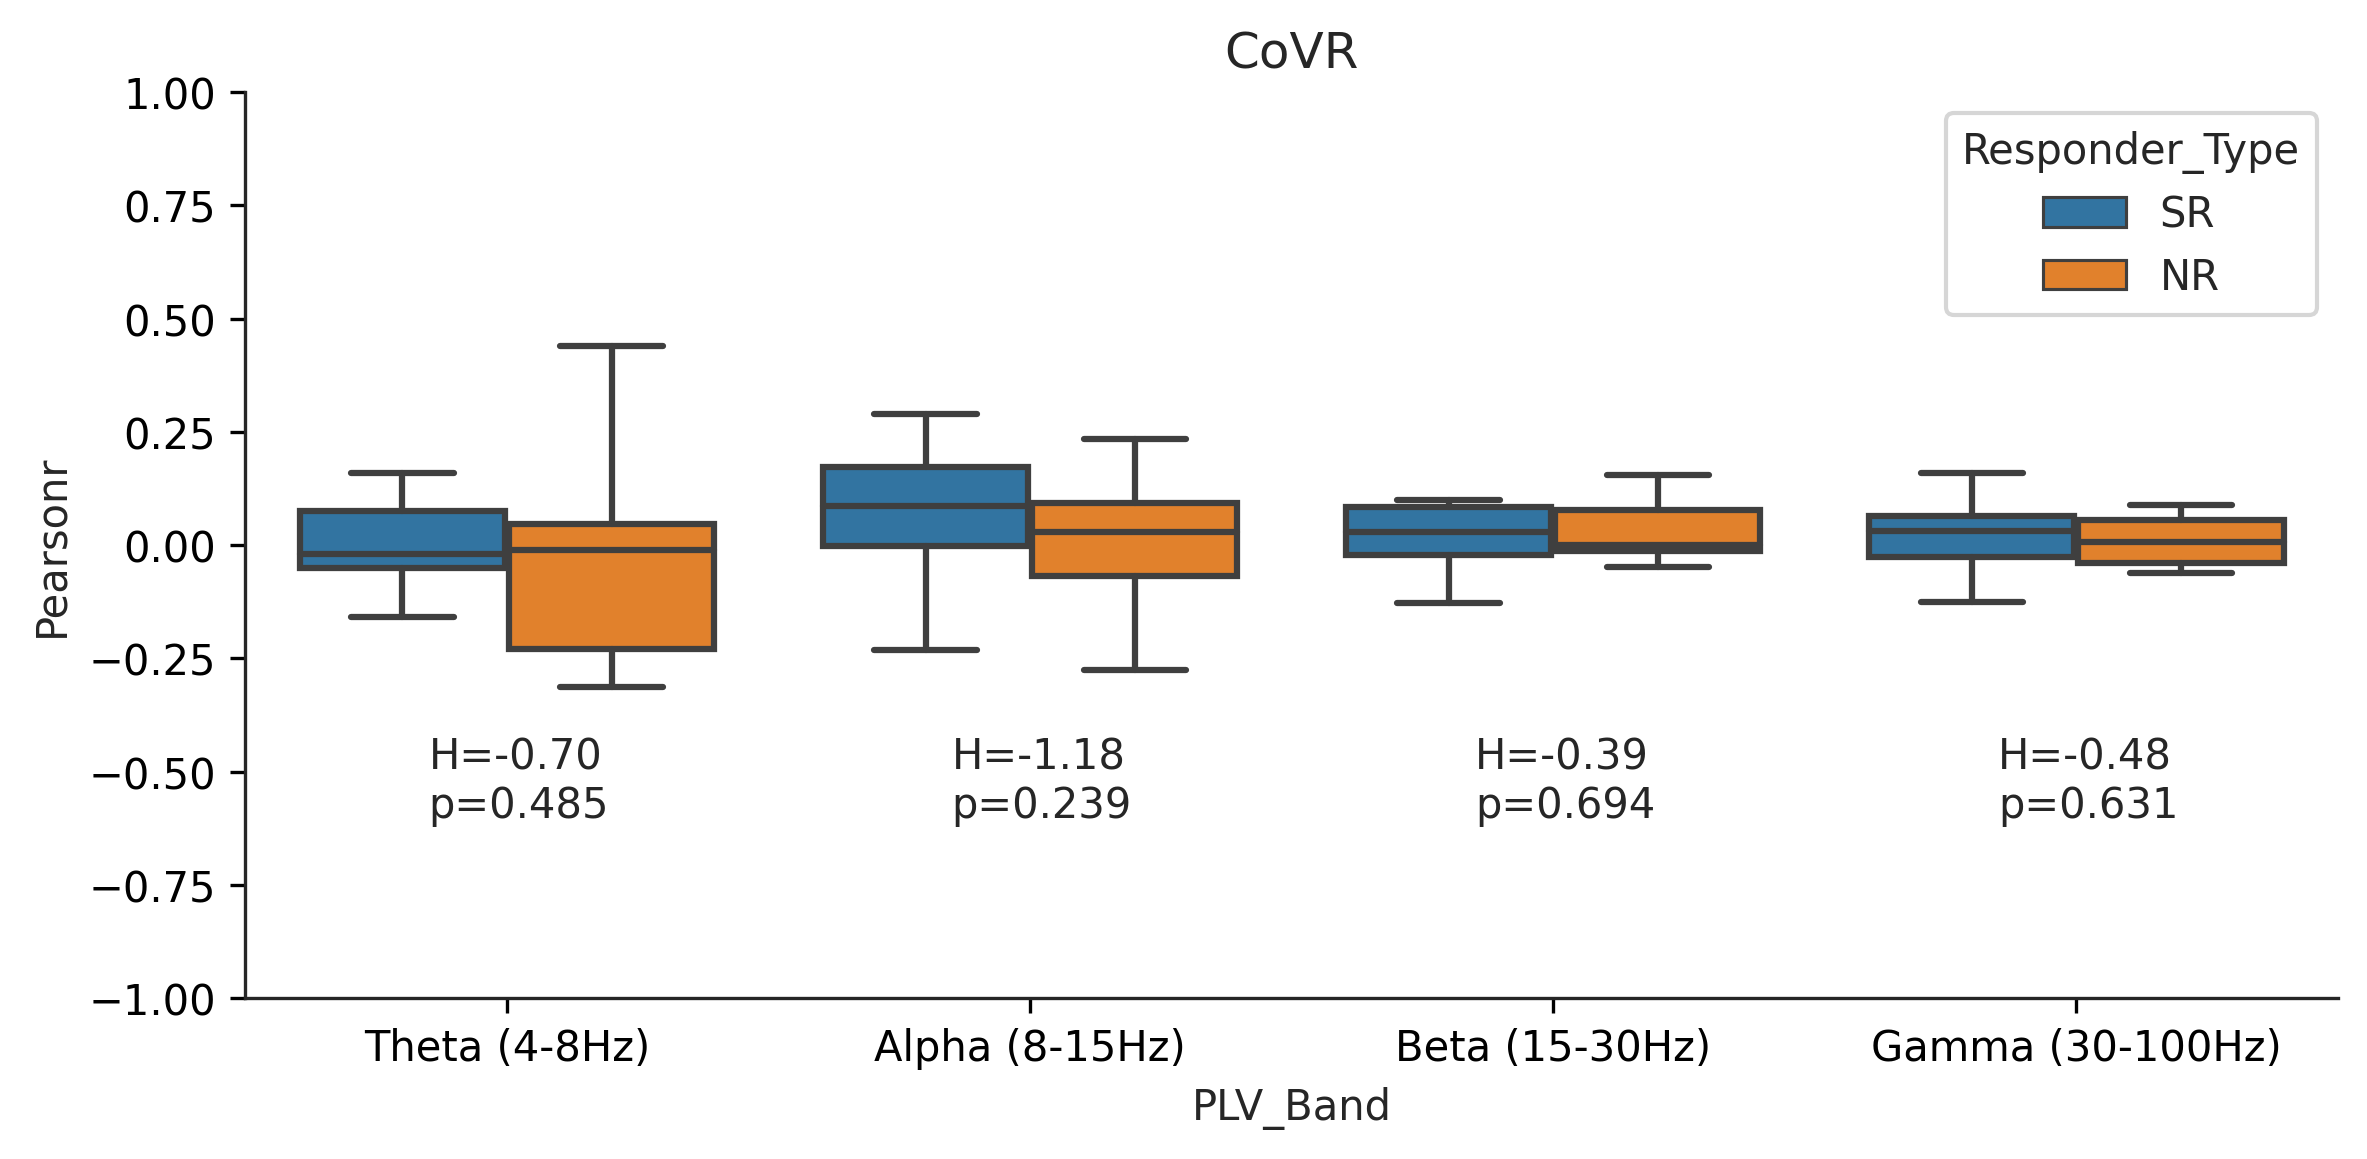

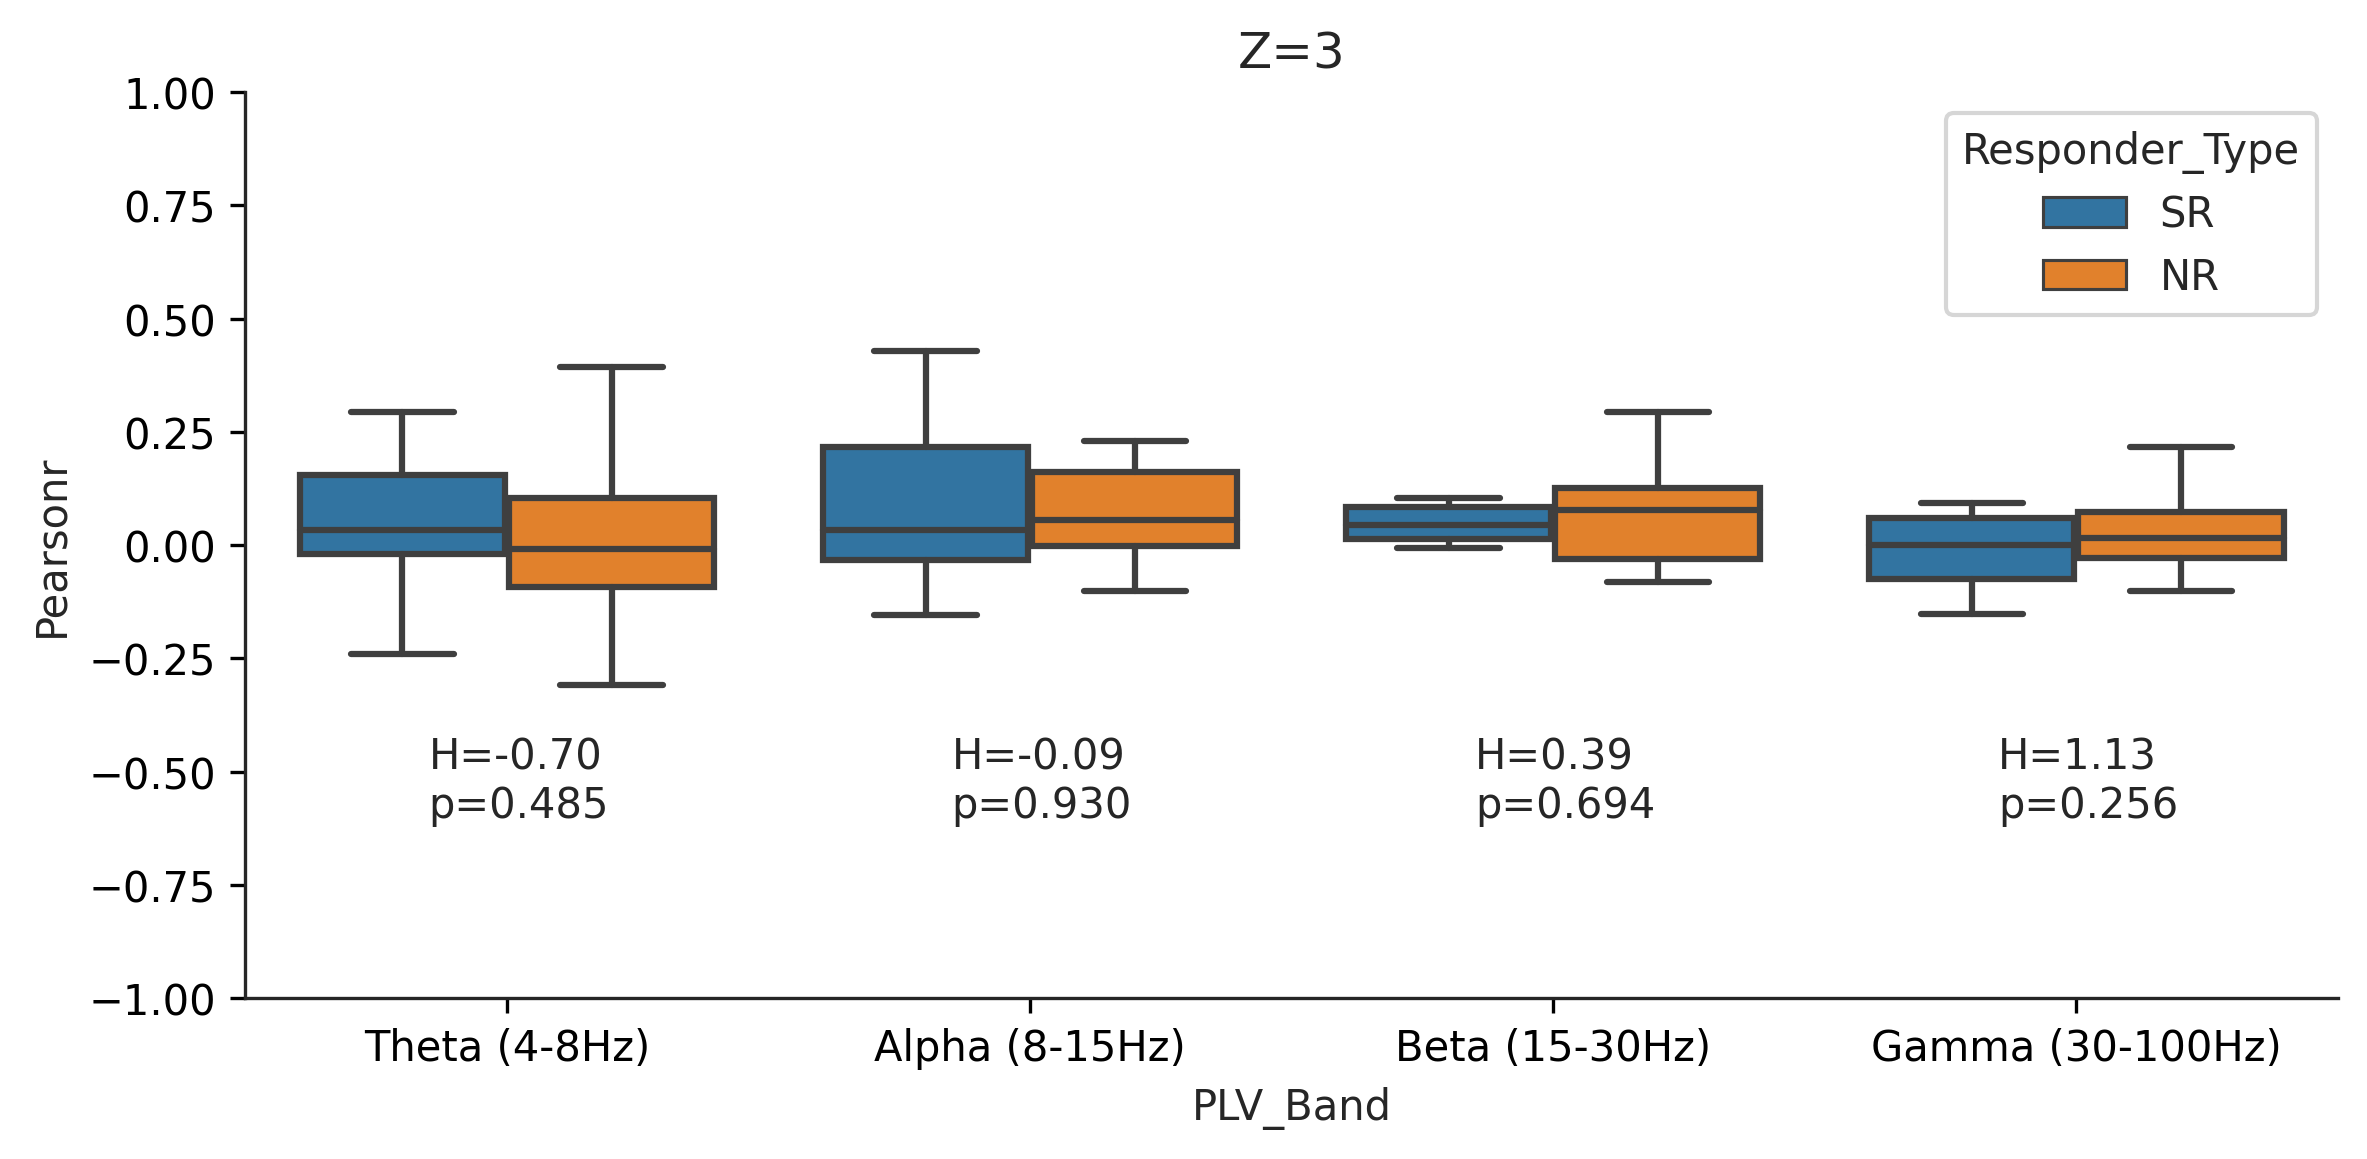

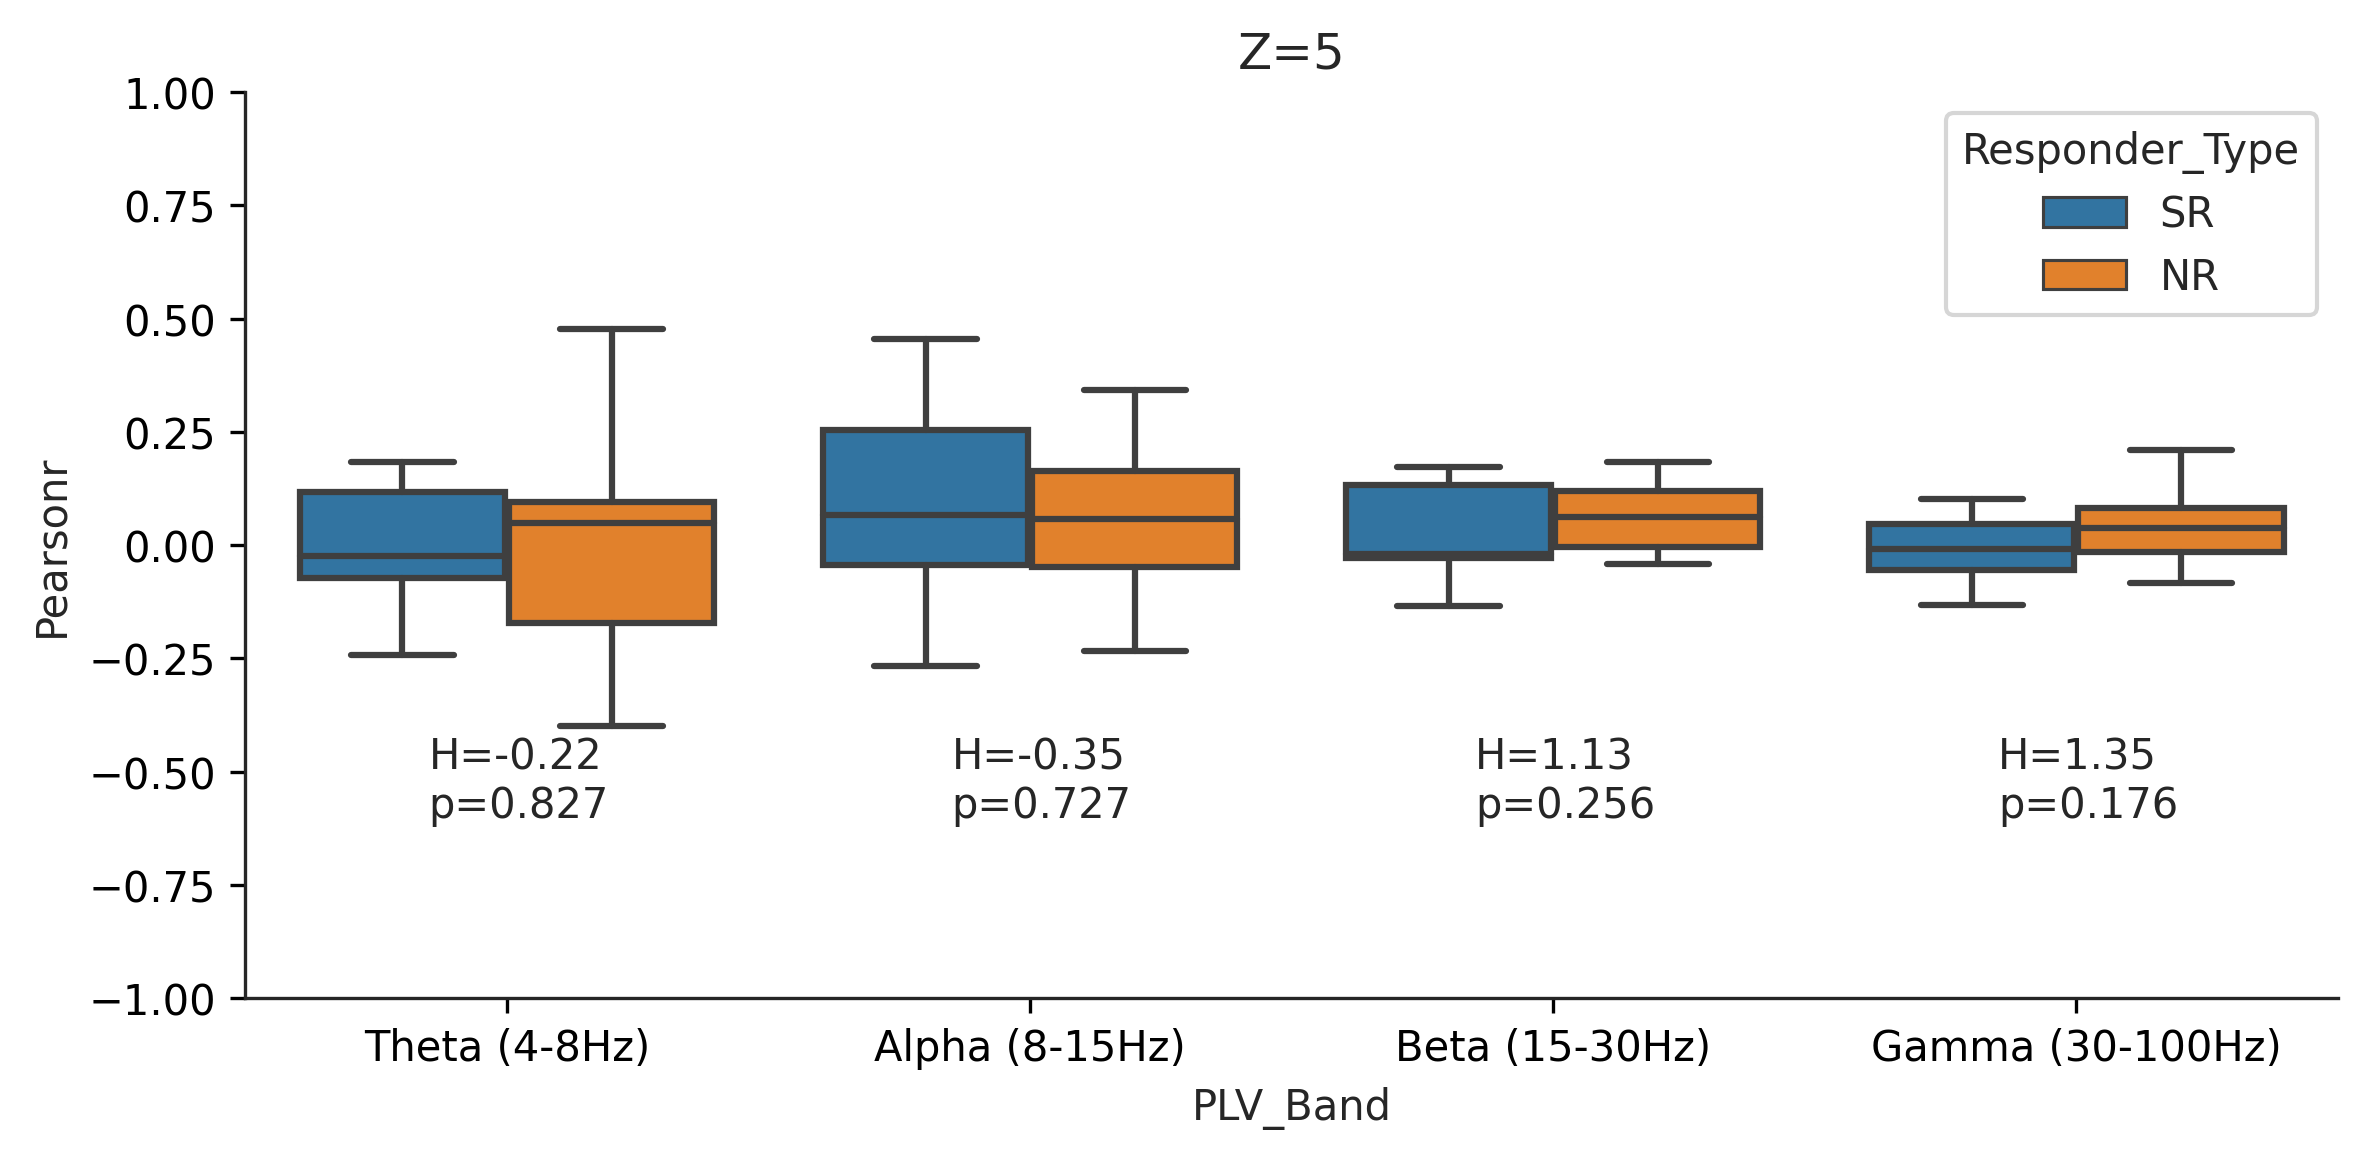

In [24]:
for llm in ['CoVR', 'Z=3', 'Z=5']: 
    PLV_SPK_Subset = PLV_SPK_Subject[(PLV_SPK_Subject['Responder_Type'].isin(['NR', 'SR']))]
    PLV_SPK_Subset = PLV_SPK_Subset[PLV_SPK_Subset['PLV_Location'] == 'PLV_Global']
    PLV_SPK_Subset = PLV_SPK_Subset[PLV_SPK_Subset['LL_Metric'] == llm]


    plt.figure(figsize=(9,4), dpi=300)
    ax = plt.subplot(111)
    ax = sns.boxplot(x='PLV_Band', y='Pearsonr', hue='Responder_Type', ax=ax,
                     data=PLV_SPK_Subset, fliersize=0)
    ax.set_ylim([-1.0, 1.0])

    for xx, band in enumerate(['Theta (4-8Hz)', 'Alpha (8-15Hz)', 'Beta (15-30Hz)', 'Gamma (30-100Hz)']):
        plvspk = PLV_SPK_Subset[PLV_SPK_Subset['PLV_Band'] == band]

        tv, pv = sp_stats.ranksums(plvspk[plvspk['Responder_Type'] == 'NR']['Pearsonr'],
                                   plvspk[plvspk['Responder_Type'] == 'SR']['Pearsonr'])
        ax.text(xx-0.15, -0.6, 'H={:0.2f}\np={:0.3f}'.format(tv,pv))
              
    ax.set_title(llm)
    plt.savefig('{}/PLV_SPK.LL_{}.svg'.format(fig_path, llm))
    plt.show()